# Gated Recurrent Units (GRU) Model Notebook

```md
@authors: Grupo 03
```

In [1]:
# Notebook Imports
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
import json
import itertools
import random

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
from tensorflow.keras import layers, preprocessing, regularizers
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from enum import Enum

In [2]:
# Model run enum
class ModelRunMode(Enum):
    """
    Enumeration of Model Run Mode.
    """
    TRAIN           = "train"           # Train Mode
    CLASSIFY        = "classify"        # Classify Mode

In [3]:
# Model run mode
# Options: 
#   ModelRunMode.TRAIN.value            (Train the model)
#   ModelRunMode.CLASSIFY.value         (Classify data)
mode = ModelRunMode.TRAIN.value
# Prefix for saving the model files
model_prefix = "gru_model_1"
file_path = "gru_model_weights"
separator_char = "\t"

In [4]:
# Parameters cell
if mode == ModelRunMode.TRAIN.value:
    # TRAIN mode: Set parameters for training
    input_csv = "../tarefa_1/test_input_dataset/merged_inputs.csv"                      # CSV file with training inputs (ID, Text)
    output_csv = "../tarefa_1/test_output_dataset/merged_outputs.csv"                   # CSV file with training outputs (ID, Label)
    test_size = 0.3                                                                     # Proportion of the dataset to use as test data
    validation_size = 0.2                                                               # Proportion of the dataset reserved as validation data
    random_state=42                                                                     # Seed for reproducible dataset splitting
    verbose = True                                                                      # Verbosity level enabler
    vocab_size = 5000                                                                   # Max vocabulary size
    seed = 42                                                                           # Global seed for reproducibility across Python, NumPy, and TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)                                            # Set environment variable for Python's internal hash seed for determinism
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"                                          # Attempt to force cuDNN to be deterministic
    random.seed(seed)                                                                   # Set Python's built-in random module seed
    np.random.seed(seed)                                                                # Set NumPy random seed
    tf.random.set_seed(seed)                                                            # Set TensorFlow random seed
elif mode == ModelRunMode.CLASSIFY.value:
    # CLASSIFY mode: Set parameters for classification
    input_csv = "../tarefa_3/classify_input_datasets/submission3_inputs.csv"                # CSV file with texts for prediction (ID, Text)
    output_csv = "../tarefa_3/classify_output_datasets/submission3_outputs_gru_model.csv"   # CSV file to store prediction result
else:
    print("The selected option is not valid. Options: \"train\" or \"classify\"!")
    SystemExit()

In [5]:
# Method to load and merge two datasets by ID column
def merge_data_by_id(input_csv, output_csv, sep="\t"):
    df_in = pd.read_csv(input_csv, sep=sep)
    df_out = pd.read_csv(output_csv, sep=sep)

    # Remove duplicates or NaNs if needed
    df_in.dropna(subset=["ID", "Text"], inplace=True)
    df_out.dropna(subset=["ID", "Label"], inplace=True)
    df_in.drop_duplicates(subset=["ID"], inplace=True)
    df_out.drop_duplicates(subset=["ID"], inplace=True)

    df_merged = pd.merge(df_in, df_out, on="ID", how="inner")
    return df_merged

# Method for text cleaning
def text_cleaning(text):
        # Download required NLTK resources
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt_tab', quiet=True)
        nltk.download('wordnet', quiet=True)
        # Convert text to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http[s]?://\S+', "", text)
        # Remove HTML tags
        text = re.sub(r"<[^>]*>", "", text)
        # Remove common LaTeX commands
        text = re.sub(r"\\[a-zA-Z]+(\{.*?\})?", "", text)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', "", text)
        # Remove punctuation
        text = re.sub(r"[^\w\s]", "", text)
        # Remove digits
        text = re.sub(r"\d+", "", text)
        # Replace newlines and extra whitespace with a single space
        text = re.sub(r"\s+", " ", text).replace('\n', " ")
        # Trim leading and trailing whitespace
        text = text.strip()
        # Tokenize text and remove stopwords using NLTK's English stopwords list
        stop_words = set(stopwords.words('english'))
        # Tokenize text
        tokens = word_tokenize(text)
        # Remove stopwords
        filtered_tokens = [tok for tok in tokens if tok not in stop_words]
        # Lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(tok) for tok in filtered_tokens]
        # Return the cleaned text as a string
        return " ".join(lemmatized_tokens)

# Method to convert labels to binary
def convert_labels_to_binary_and_get_text(df_merged):
    df_merged["Label"] = df_merged["Label"].str.lower().str.strip()
    y = np.where(df_merged["Label"] == "ai", 1.0, 0.0)
    texts = df_merged["Text"].tolist()
    return y, texts

# Method to plot the learning curves
def plot_learning_curves(history):
    # Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

# Method to check label distribution
def check_label_distribution(df_merged):
    label_counts = df_merged["Label"].value_counts(dropna=False)
    print("Label distribution:\n", label_counts)

# Method to print the first 5 cleaned texts
def debug_text_cleaning(df_merged):
    for i in range(min(5, len(df_merged))):
        print(df_merged["Text"].iloc[i])

In [6]:
# Method to create a GRU-Based classification model
def build_gru_model(vocab_size: int, max_len: int, embedding_dim=128, gru_units=64, num_layers=1, dropout_rate=0.0, learning_rate=1e-3, l2_reg=1e-4):
    """
    Create a GRU-based classification model with given hyperparameters.
    """
    model = keras.Sequential()
    
    # Embedding layer
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

    # Stack GRU Layers and apply dropout to GRU's internal state
    for i in range(num_layers):
        # For stacked GRUs, the first N-1 GRUs typically return sequences
        return_seq = (i < num_layers - 1)
        model.add(layers.Bidirectional(layers.GRU(gru_units, return_sequences=return_seq, dropout=dropout_rate, kernel_regularizer=regularizers.l2(l2_reg))))
    
    # Final Dense layer for classification
    model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg)))
    
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Print model
    print(model.summary())
    return model

In [7]:
# Method to tune GRU model hyperparameters
def tune_gru_hyperparams(X_train, y_train, X_val, y_val, vocab_size, max_len, param_grid, early_stop_patience=3, reduce_lr_on_plateau_patience=2, reduce_lr_on_plateau_factor=0.5, verbose=1):
    best_acc = 0.0
    best_params = None
    best_model = None
    best_loss = float('inf')

    # Early stopping and reduce learning rate callbacks
    callback_list = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_on_plateau_factor, patience=reduce_lr_on_plateau_patience, verbose=verbose)
    ]
    
    # Generate all combinations of hyperparams from the dictionary
    keys = list(param_grid.keys())
    all_combinations = list(itertools.product(*(param_grid[k] for k in keys)))
    
    for combination in all_combinations:
        # Build a dictionary with the current params
        current_params = dict(zip(keys, combination))
        
        # Build model
        model = build_gru_model(vocab_size=vocab_size, max_len=max_len, embedding_dim=current_params['embedding_dim'], gru_units=current_params['gru_units'], num_layers=current_params['num_layers'], dropout_rate=current_params['dropout_rate'], learning_rate=current_params['learning_rate'])
        
        # Train model
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=current_params['epochs'], batch_size=current_params['batch_size'], callbacks=callback_list, verbose=verbose)
        
        # Evaluate final val accuracy
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=verbose)
        
        print("Params:", current_params, "| Val Acc = {:.4f}".format(val_acc))
        
        # Keep track of best accuracy (if two combinations yield the same accuracy, we pick the one with the lower validation loss)
        if (val_acc > best_acc) or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_params = current_params
            best_model = model
    
    print("Best val acc = {:.4f}".format(best_acc))
    print("Best hyperparams:", best_params)
    return best_model, best_params

Tensorflow List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Label distribution:
 Label
Human    942
AI       942
Name: count, dtype: int64
present general numerical scheme practical implementation statistical moment closure suitable modeling complex largescale nonlinear system building recently developed equationfree method approach numerically integrates closure dynamic equation may even available closed form although closure dynamic introduce statistical assumption unknown validity significant computational advantage typically fewer degree freedom may much less stiff original detailed model closure method principle applied wide class nonlinear problem including stronglycoupled system either deterministic stochastic may scale separation demonstrate equationfree approach implementing entropybased eyinklevermore closure nonlinear stochastic partial differential equation
present paper aim introducing innovative technology based concept sensory substitution

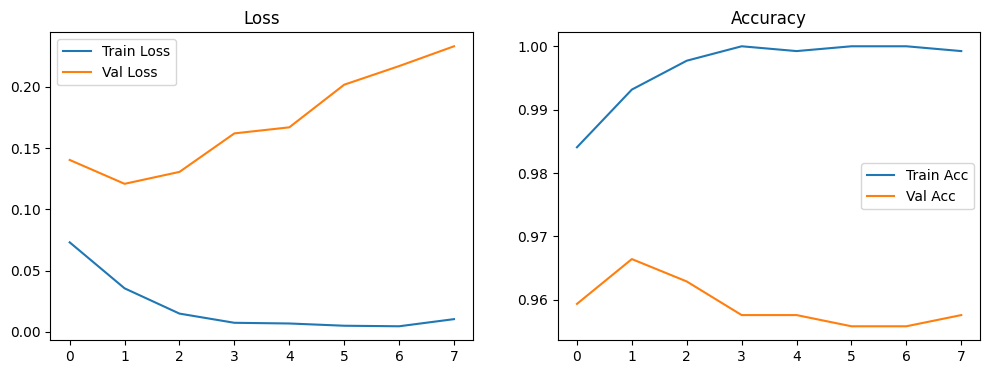

18/18 [==============================] - 1s 5ms/step
F1 Score (Teste): 0.9582
Recall (Teste): 0.9717
Precision (Teste): 0.9450
Matriz de Confusão (Teste):
 [[267  16]
 [  8 275]]
Saving model to: gru_model_weights\gru_model_1_model


INFO:tensorflow:Assets written to: gru_model_weights\gru_model_1_model\assets


INFO:tensorflow:Assets written to: gru_model_weights\gru_model_1_model\assets


Saving tokenizer to: gru_model_weights\gru_model_1_tokenizer
Save configuration to: gru_model_weights\gru_model_1_config.json
GRU Model, tokenizer and configuration stored under gru_model_weights. Finished Training!


In [8]:
if mode == ModelRunMode.TRAIN.value:
    # Check if Tensorflow is listing available GPUs (if not, continue with CPU)
    print("Tensorflow List of GPUs:", tf.config.list_physical_devices('GPU'))

    # Load data
    df_merged = merge_data_by_id(input_csv, output_csv, sep=separator_char)

    # Check label distribution
    check_label_distribution(df_merged=df_merged)

    # Text cleaning
    df_merged["Text"] = df_merged["Text"].apply(text_cleaning)

    # Print the first 5 cleaned texts
    debug_text_cleaning(df_merged)

    # Convert Label: "AI" -> 1, "Human" -> 0
    y, texts = convert_labels_to_binary_and_get_text(df_merged)

    # Creating tokenizer
    tokenizer = preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)

    # Convert to sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Calculate 90th percentile sequence length and pad sequences accordingly
    lengths = [len(seq) for seq in sequences]
    max_len = int(np.percentile(lengths, 90))

    # Pad sequences
    X = preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

    # Split entire dataset into train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state,stratify=y)

    # Split train_val into train vs val
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_size, random_state=random_state, stratify=y_train_val)

    param_grid = {
        'embedding_dim': [32, 64],
        'gru_units': [32, 64],
        'num_layers': [1],
        'learning_rate': [1e-4, 1e-3],
        'dropout_rate': [0.1, 0.2],
        'epochs': [4, 8],
        'batch_size': [8, 16]
    }

    # Finetune GRU Hyperparameters
    best_model, best_params = tune_gru_hyperparams(X_train, y_train, X_val, y_val, vocab_size=vocab_size, max_len=max_len, param_grid=param_grid)

    # Display model sumary
    best_model.summary()

    # Evaluate best_model on the validation set
    val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=1)
    print(f"Validation Accuracy (best model): {val_acc:.4f}")
    print(f"Validation Loss (best model): {val_loss:.4f}")

    # Re-fit the best_model on the entire train_val set
    history_final = best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1, validation_data=(X_test, y_test))

    # Evaluate final model on test
    final_test_loss, final_test_acc = best_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Accuracy (after re-fit on train_val): {final_test_acc:.4f}")
    print(f"Test Loss (after re-fit on train_val): {final_test_loss:.4f}")

    # Plot training curves for final re-fit
    plot_learning_curves(history_final)

    y_test_pred = best_model.predict(X_test)
    y_test_pred_binary = (y_test_pred > 0.5).astype(int)

    f1_test = f1_score(y_test, y_test_pred_binary)
    recall_test = recall_score(y_test, y_test_pred_binary)
    precision_test = precision_score(y_test, y_test_pred_binary)
    cm_test = confusion_matrix(y_test, y_test_pred_binary)

    print(f"F1 Score (Teste): {f1_test:.4f}")
    print(f"Recall (Teste): {recall_test:.4f}")
    print(f"Precision (Teste): {precision_test:.4f}")
    print("Matriz de Confusão (Teste):\n", cm_test)

    # Construct the file paths
    model_path = os.path.join(file_path, f"{model_prefix}_model")
    tokenizer_path = os.path.join(file_path, f"{model_prefix}_tokenizer")
    config_path = os.path.join(file_path, f"{model_prefix}_config.json")

    # Save the model weights
    print("Saving model to:", model_path)
    best_model.save(model_path)

    # Save the model tokenizer
    print("Saving tokenizer to:", tokenizer_path)
    with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)
    
    # Save configuration
    print("Save configuration to:", config_path)
    config_data = {
        "max_len": max_len,
        "vocab_size": vocab_size
    }

    with open(config_path, "w") as f:
        json.dump(config_data, f)

    # Print end message
    print(f"GRU Model, tokenizer and configuration stored under {file_path}. Finished Training!")

if mode == ModelRunMode.CLASSIFY.value:
    # Construct the file paths
    model_path = os.path.join(file_path, f"{model_prefix}_model")
    tokenizer_path = os.path.join(file_path, f"{model_prefix}_tokenizer")
    config_path = os.path.join(file_path, f"{model_prefix}_config.json")

    # Loading model
    print("Loading model from:", model_path)
    model = tf.keras.models.load_model(model_path)

    # Loading tokenizer
    print("Loading tokenizer from:", tokenizer_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Loading configuration
    print("Loading configuration from:", config_path)
    with open(config_path, "r") as f:
         config_data = json.load(f)

    # Retrieve the saved configuration max_len
    max_len = config_data["max_len"]

    # Reading input for classification
    df_new = pd.read_csv(input_csv, sep=separator_char)
    if "ID" not in df_new.columns or "Text" not in df_new.columns:
        raise ValueError("Input CSV must have 'ID' and 'Text' columns for classification.")

    # Clean text
    df_new["Text"] = df_new["Text"].apply(text_cleaning)
    texts = df_new["Text"].tolist()

    # Convert to sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad
    X_new = preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

    # Predict
    preds = model.predict(X_new)
    pred_bin = (preds >= 0.5).astype(int).flatten()
    pred_label = np.where(pred_bin == 1, "AI", "Human")

    # Save result
    df_out = pd.DataFrame({"ID": df_new["ID"], "Label": pred_label})
    df_out.to_csv(output_csv, sep=separator_char, index=False)
    print(f"Predictions saved to {output_csv}")

    # Load the validation dataset
    df_true = pd.read_csv("../tarefa_1/validation_dataset/dataset3_disclosed_output.csv", sep="\t")

    # Merge the datasets on the "ID" column, adding suffixes to distinguish the identical column names
    df_merged = pd.merge(df_true, df_out, on="ID", suffixes=('_true', '_pred'))

    # Calculate the number of correct predictions by comparing the "Label" columns
    num_correct = (df_merged["Label_true"] == df_merged["Label_pred"]).sum()

    # Calculate the percentage of correct predictions
    accuracy_percentage = (num_correct / len(df_merged)) * 100

    print(f"Accuracy: {accuracy_percentage:.2f}%")
